In [1]:
%matplotlib inline

In [2]:
from __future__ import division,print_function

import os, json
import shutil
from glob import glob
import random
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
from importlib import reload
import utils; reload(utils)
from utils import plots

In [3]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla P100-PCIE-16GB (CNMeM is disabled, cuDNN 5110)


## Create validation set and sample

In [5]:
NB_ROOT = os.getcwd()

In [6]:
DATA_HOME_DIR = os.path.join(NB_ROOT, "data/state-farm-distracted-driver-detection")
results_path = os.path.join(DATA_HOME_DIR, 'results')

In [7]:
%mkdir -p $DATA_HOME_DIR
%cd $DATA_HOME_DIR
%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test/unknown
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/leo/src/fastai-courses/deeplearning1/nbs/data/state-farm-distracted-driver-detection


In [8]:
# !kg download -c state-farm-distracted-driver-detection
!mv test/*.jpg test/unknown

mv: cannot stat `test/*.jpg': No such file or directory


In [9]:
def create_valid_set(train_root='train', valid_root="valid", valid_rate=0.1):
    labels = os.listdir(train_root)
    for label in labels:
        train_label_dir = os.path.join(train_root, label)
        valid_label_dir = os.path.join(valid_root, label)
        os.makedirs(valid_label_dir, exist_ok=True)
        files = os.listdir(train_label_dir)
        for file in random.sample(files, k=int(len(files) * valid_rate)):
            shutil.move(os.path.join(train_label_dir, file), valid_label_dir)
# create_valid_set()

In [10]:
def create_sample_set(rate=0.003):
    for dataset in ['train', 'valid', 'test']:
        labels = os.listdir(dataset)
        if dataset == "valid":
            # use a higher smple rate for the validation dataset
            # because they have fewer items
            sample_rate = rate*5
        else:
            sample_rate = rate
        for label in labels:
            src_dir = os.path.join(dataset, label)
            dst_dir = os.path.join('sample', dataset, label)
            os.makedirs(dst_dir, exist_ok=True)
            files = os.listdir(src_dir)
            for file in random.sample(files, k=int(len(files) * sample_rate)):
                shutil.copy(os.path.join(src_dir, file), dst_dir)
# create_sample_set()

# Build Model

In [11]:
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


In [12]:
def addConvBlock(model, layers, filters):
    """
        Adds a specified number of ZeroPadding and Covolution layers
        to the model, and a MaxPooling layer at the very end.

        Args:
            layers (int):   The number of zero padded convolution layers
                            to be added to the model.
            filters (int):  The number of convolution filters to be 
                            created for each layer.
    """
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    

In [13]:
def addFCBlock(model):
    """
        Adds a fully connected layer of 4096 neurons to the model with a
        Dropout of 0.5

        Args:   None
        Returns:   None
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))


In [14]:
# Build Vgg model
def build_model():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

    addConvBlock(model, 2, 64)
    addConvBlock(model, 2, 128)
    addConvBlock(model, 3, 256)
    addConvBlock(model, 3, 512)
    addConvBlock(model, 3, 512)

    model.add(Flatten())


    addFCBlock(model)
    addFCBlock(model)

    model.add(Dense(1000, activation='softmax'))

    fname = 'vgg16.h5'
    model.load_weights(get_file(fname, 'http://files.fast.ai/models/'+fname, cache_subdir='models'))
    return model
model = build_model()

# Train

In [15]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        # 224x224 is the image size used by ImageNet
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [16]:
_path = DATA_HOME_DIR
# _path = DATA_HOME_DIR + '/sample' # Only for sample tests!
test_path = os.path.join(DATA_HOME_DIR, 'test')
results_path = os.path.join(DATA_HOME_DIR, 'results')
train_path = os.path.join(_path, 'train')
valid_path = os.path.join(_path, 'valid')
test_path = os.path.join(_path, 'test')

In [17]:
! cd $NB_ROOT
BATCH_SIZE=64

train_batches = get_batches(train_path, batch_size=BATCH_SIZE)
valid_batches = get_batches(valid_path, batch_size=BATCH_SIZE*2)

Found 20187 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.


## Fine tune the last layer

In [18]:
def finetune(model, output_size, lr=0.001):
    # Replace the last layer with a new Dense
    model.pop()
    for layer in model.layers:
        layer.trainable=False
    model.add(Dense(output_size, activation='softmax'))
    model.compile(
        optimizer=Adam(lr=lr),
        loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
finetune(model, train_batches.nb_class)

In [20]:
model.optimizer.lr = 0.01

In [21]:
def fit_model(model):
    no_of_epochs = 5
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print("Running epoch: %d" % epoch)
        model.fit_generator(
            train_batches, samples_per_epoch=train_batches.nb_sample,
            nb_epoch=1,
            validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample
        )
        latest_weights_filename = 'ft%d.h5' % epoch
        model.save_weights(results_path+latest_weights_filename)
        print("Completed %s fit operations" % no_of_epochs)

In [22]:
fit_model(model)

Running epoch: 0
Epoch 1/1
20187/20187 [==============================] - 5263s - loss: 10.4317 - acc: 0.2994 - val_loss: 9.9219 - val_acc: 0.3599
Completed 5 fit operations
Running epoch: 1
Epoch 1/1
20187/20187 [==============================] - 5217s - loss: 10.3765 - acc: 0.3297 - val_loss: 9.6659 - val_acc: 0.3871
Completed 5 fit operations
Running epoch: 2
Epoch 1/1
20187/20187 [==============================] - 5217s - loss: 10.2584 - acc: 0.3427 - val_loss: 9.5671 - val_acc: 0.3965
Completed 5 fit operations
Running epoch: 3
Epoch 1/1
20187/20187 [==============================] - 5209s - loss: 10.2330 - acc: 0.3501 - val_loss: 9.5788 - val_acc: 0.3987
Completed 5 fit operations
Running epoch: 4
Epoch 1/1
20187/20187 [==============================] - 5216s - loss: 10.2724 - acc: 0.3474 - val_loss: 9.4396 - val_acc: 0.4099
Completed 5 fit operations


## Training more layers

In [175]:
first_dense_layer_idx = [
    idx for idx, layer in enumerate(model.layers) if type(layer) is Dense
][0]

for layer in layers[first_dense_layer_idx:]:
    layer.trainable=True


In [176]:
fit_model(model)

Running epoch: 0
Epoch 1/1
20187/20187 [==============================] - 5242s - loss: 10.1959 - acc: 0.3549 - val_loss: 9.6843 - val_acc: 0.3925
Completed 5 fit operations
Running epoch: 1
Epoch 1/1
20187/20187 [==============================] - 5232s - loss: 10.2287 - acc: 0.3537 - val_loss: 9.3517 - val_acc: 0.4171
Completed 5 fit operations
Running epoch: 2
Epoch 1/1
20187/20187 [==============================] - 5230s - loss: 10.2638 - acc: 0.3520 - val_loss: 9.6300 - val_acc: 0.3961
Completed 5 fit operations
Running epoch: 3
Epoch 1/1
20187/20187 [==============================] - 5231s - loss: 10.2615 - acc: 0.3537 - val_loss: 9.6404 - val_acc: 0.3943
Completed 5 fit operations
Running epoch: 4
Epoch 1/1
20187/20187 [==============================] - 5232s - loss: 10.2401 - acc: 0.3542 - val_loss: 9.4535 - val_acc: 0.4090
Completed 5 fit operations


In [182]:
test_batches = get_batches(
    test_path, batch_size=BATCH_SIZE * 2, shuffle=False, class_mode=None)

Found 79726 images belonging to 1 classes.


## Predict

In [45]:
def predict(model, test_batches):
    return model.predict_generator(test_batches, test_batches.nb_sample)


In [ ]:
preds = predict(model, test_batches)

In [ ]:
sbm = pd.DataFrame(preds.copy(), columns="c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(','))
sbm['img'] = [f.replace('unknown/', '') for f in test_batches.filenames]
for col in "c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(','):
    sbm[col] = np.clip(sbm[col], 0.1, 0.9)

sbm = sbm.set_index(['img'])
sbm = sbm.sort_index()

In [ ]:
sbm.to_csv('submission.csv')

In [ ]:
!kg submit -c state-farm-distracted-driver-detection submission.csv

# Predict on the validation data set

In [81]:
val_preds = predict(model, valid_batches)

In [95]:
valid_batches.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [103]:
pred_class = np.argmax(val_preds, axis=1)

In [134]:
correct = np.where(valid_batches.classes == pred_class)[0]

In [136]:
incorrect = np.where(valid_batches.classes != pred_class)[0]

In [150]:
def plot_imgs(idxes, size=5, titles=None):
    idxes = np.random.permutation(idxes)[:size]
    imgs = [
        image.load_img(
            os.path.join(valid_path, valid_batches.filenames[i])
        ) for i in idxes
    ]
    if titles:
        titles = [titles[i] for i in idxes]
    plots(imgs, titles=titles)

In [153]:
indices2labels = {val: key for key, val in valid_batches.class_indices.items()}

In [158]:
val_titles = [
    '{} vs {}'.format(indices2labels[vc], indices2labels[pc])
    for vc, pc in  zip(valid_batches.classes, pred_class)
]

**The 10 classes:**

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger


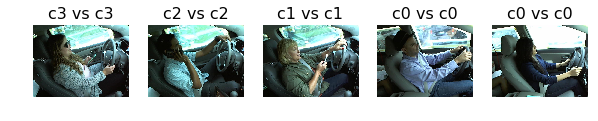

In [163]:
plot_imgs(correct, titles=val_titles)

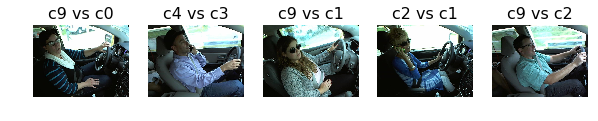

In [167]:
plot_imgs(incorrect, titles=val_titles)